In [1]:
import torch
import torch.nn.functional as F

import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from torchvision import transforms

from PIL import Image

from captum.attr import IntegratedGradients, GradientShap, Occlusion, NoiseTunnel
from captum.attr import visualization as viz

## Get Dataset Statistics

In [2]:
from utils.preprocessing import get_mean_std, get_label_map

mean, std = get_mean_std('dataset_1500')
label_map = get_label_map('dataset_1500')

Calculating mean and std: 100%|██████████| 141/141 [00:12<00:00, 10.98it/s]


## Load Model

In [3]:
from models import SimpleCNN

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

model = SimpleCNN(num_classes=len(label_map))
model.load_state_dict(torch.load('ckpts/simple_cnn_best_val_loss.pth', weights_only=True))

model.to(device)
model = model.eval()

device: mps


## Image Preprocessing

In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# img = Image.open('assets/red-billed-blue-magpie.png')
img = Image.open('assets/taiwan-blue-magpie.png')
# img = Image.open('assets/yellow-billed-blue-magpie.png')

transformed_img = transform(img)
input = transformed_img.unsqueeze(0)
print(input.shape)

torch.Size([1, 3, 256, 256])


## Predict

In [5]:
output = model(input.to(device))
output = F.softmax(output, dim=1)
prob, pred = torch.max(output, 1)

pred.squeeze_()
predicted_label = label_map[pred.item()]
print('Predicted:', predicted_label, '(', prob.squeeze().item(), ')')

Predicted: taiwan-blue-magpie ( 0.9970692992210388 )


## Gradient-based attribution

In [6]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

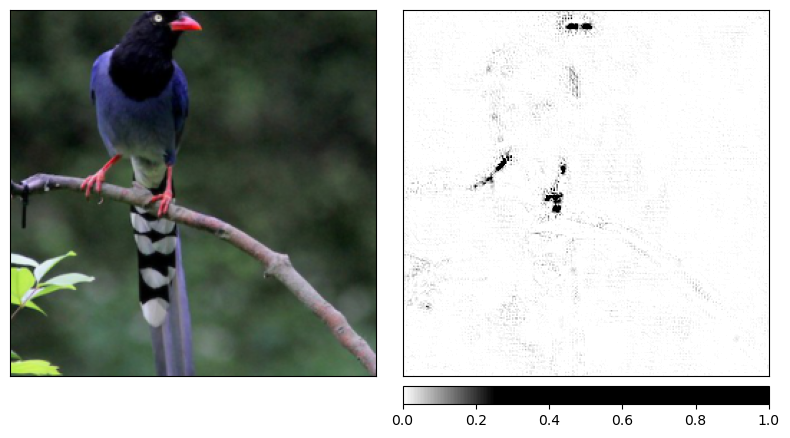

In [7]:
model = model.to('cpu')
model = model.eval()
integrated_gradients = IntegratedGradients(model)

attributions_ig = integrated_gradients.attribute(input, target=pred, n_steps=200)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(img),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

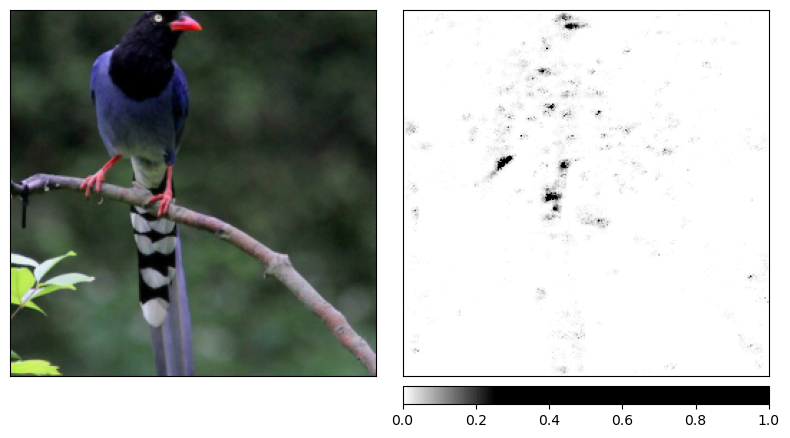

In [8]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(img),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

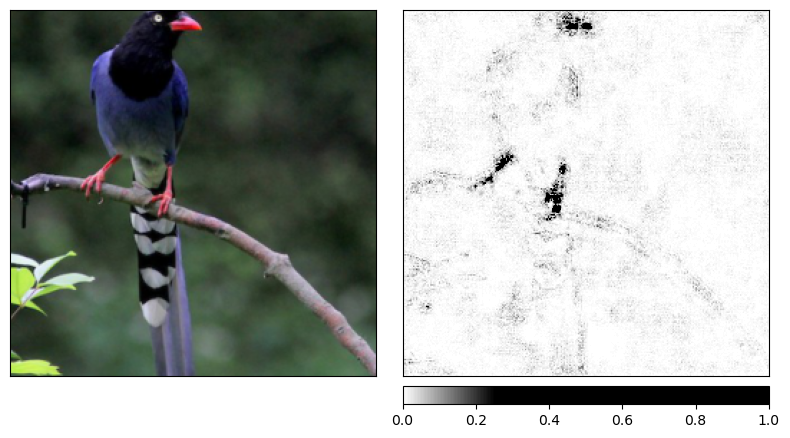

In [9]:
torch.manual_seed(0)
np.random.seed(0)

model = model.to('cpu')
model = model.eval()
gradient_shap = GradientShap(model)

rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(img),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

## Occlusion-based attribution

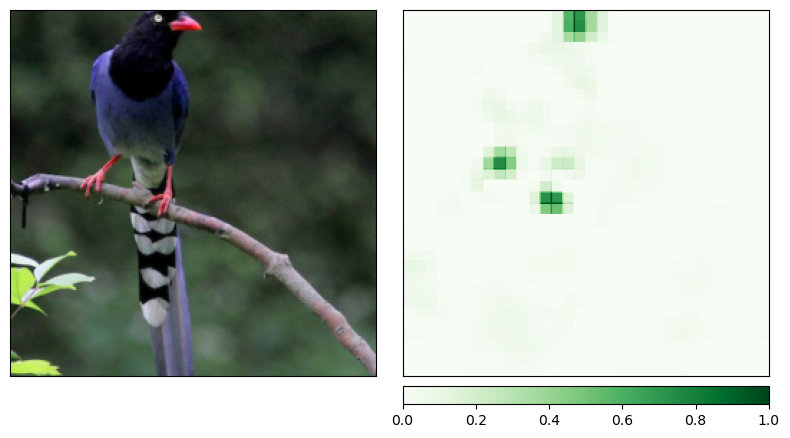

In [10]:
model.to(device)
model = model.eval()
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input.to(device),
                                       strides = (3, 8, 8),
                                       target=pred,
                                       sliding_window_shapes=(3, 15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.array(img),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)